In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('所持基金.csv',encoding='gbk')
df.head()

,净值日期,单位净值,累计净值,日增长率,申购状态,赎回状态,分红送配
0,2020-08-19,2.938,3.013,-2.91,限制大额申购,开放赎回,NaN
1,2020-08-20,2.934,3.009,-0.14,限制大额申购,开放赎回,NaN
2,2020-08-21,2.967,3.042,1.12,限制大额申购,开放赎回,NaN
3,2020-08-24,2.967,3.042,0.00,限制大额申购,开放赎回,NaN
4,2020-08-25,3.006,3.081,1.31,限制大额申购,开放赎回,NaN


In [5]:
data = df['单位净值']
SEQ_LEN = 15
MEAN = data.mean()
STD = data.std()

data = (data - MEAN) / STD

In [6]:
data

0     -1.205602
1     -1.215413
2     -1.134471
3     -1.134471
4     -1.038813
         ...   
239    0.329839
240    0.332291
241    0.197389
242   -0.222037
243   -0.185245
Name: 单位净值, Length: 244, dtype: float64

In [7]:
def load_data(data,seq_len,is_shuffle):
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index:index + sequence_length])
    result = np.array(result)
    if is_shuffle:
        np.random.shuffle(result)
    x_train = result[:,:-1]
    y_train = result[:,-1]
    x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
    
    return x_train,y_train

In [9]:
from tensorflow.keras.layers import Dense,Activation,Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential

x_train,y_train = load_data(data,SEQ_LEN,True)

In [10]:
#建立计算模型
def build_model():
    model = Sequential()
    model.add(LSTM(50,return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(100,return_sequences = False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.add(Activation('linear'))
    model.compile(loss='mse',optimizer='rmsprop')
    return model

In [11]:
#用准备好的数据对模型进行训练
model = build_model()
model.fit(x_train,y_train,batch_size=128,epochs=100,validation_split=0.05)

Epoch 1/100
2/2 [==============================] - 4s 674ms/step - loss: 0.8625 - val_loss: 0.2923
Epoch 2/100
2/2 [==============================] - 0s 49ms/step - loss: 0.2522 - val_loss: 0.2097
Epoch 3/100
2/2 [==============================] - 0s 49ms/step - loss: 0.2078 - val_loss: 0.1973
Epoch 4/100
2/2 [==============================] - 0s 48ms/step - loss: 0.1976 - val_loss: 0.1894
Epoch 5/100
2/2 [==============================] - 0s 47ms/step - loss: 0.2077 - val_loss: 0.2263
Epoch 6/100
2/2 [==============================] - 0s 49ms/step - loss: 0.2179 - val_loss: 0.1872
Epoch 7/100
2/2 [==============================] - 0s 49ms/step - loss: 0.1856 - val_loss: 0.1798
Epoch 8/100
2/2 [==============================] - 0s 50ms/step - loss: 0.1857 - val_loss: 0.1778
Epoch 9/100
2/2 [==============================] - 0s 52ms/step - loss: 0.1806 - val_loss: 0.1608
Epoch 10/100
2/2 [==============================] - 0s 44ms/step - loss: 0.1761 - val_loss: 0.1592
Epoch 11/100
2/2 [

Epoch 84/100
2/2 [==============================] - 0s 47ms/step - loss: 0.0742 - val_loss: 0.0294
Epoch 85/100
2/2 [==============================] - 0s 47ms/step - loss: 0.0866 - val_loss: 0.0303
Epoch 86/100
2/2 [==============================] - 0s 46ms/step - loss: 0.0662 - val_loss: 0.0387
Epoch 87/100
2/2 [==============================] - 0s 46ms/step - loss: 0.0615 - val_loss: 0.0427
Epoch 88/100
2/2 [==============================] - 0s 48ms/step - loss: 0.0619 - val_loss: 0.0443
Epoch 89/100
2/2 [==============================] - 0s 45ms/step - loss: 0.0659 - val_loss: 0.0424
Epoch 90/100
2/2 [==============================] - 0s 47ms/step - loss: 0.0651 - val_loss: 0.0352
Epoch 91/100
2/2 [==============================] - 0s 46ms/step - loss: 0.0573 - val_loss: 0.0307
Epoch 92/100
2/2 [==============================] - 0s 47ms/step - loss: 0.0572 - val_loss: 0.0506
Epoch 93/100
2/2 [==============================] - 0s 49ms/step - loss: 0.0656 - val_loss: 0.0480
Epoch 94/1

In [14]:
#股票当日最高价格预测模型
def predict_point_by_point(model,data):
    predicted = model.predict(data)
    predicted = np.reshape(predicted,(predicted.size,))
    return predicted

In [15]:
#对所有数据按时序进行预测
x_test,y_test = load_data(data,SEQ_LEN,False)
predict_data = predict_point_by_point(model,x_test)

In [16]:
#恢复数值量级
y_test = y_test * STD + MEAN
predict_data = predict_data * STD + MEAN

In [23]:
#将日期，预测结果与测试答案合并为新的数据
list_time = df['净值日期'][16:]
df1 = pd.DataFrame()
df1['日期'] = list_time
df1['预测最高成交价'] = predict_data
df1['实际最高成交价'] = y_test
df1.head(10)


,日期,预测最高成交价,实际最高成交价
16,2020-09-10,2.993925,2.800
17,2020-09-11,2.916015,2.805
18,2020-09-14,2.859404,2.849
19,2020-09-15,2.846570,2.814
20,2020-09-16,2.850297,2.852
21,2020-09-17,2.872303,2.789
22,2020-09-18,2.879114,2.746
23,2020-09-21,2.863478,2.779
24,2020-09-22,2.852217,2.756
25,2020-09-23,2.842196,2.768


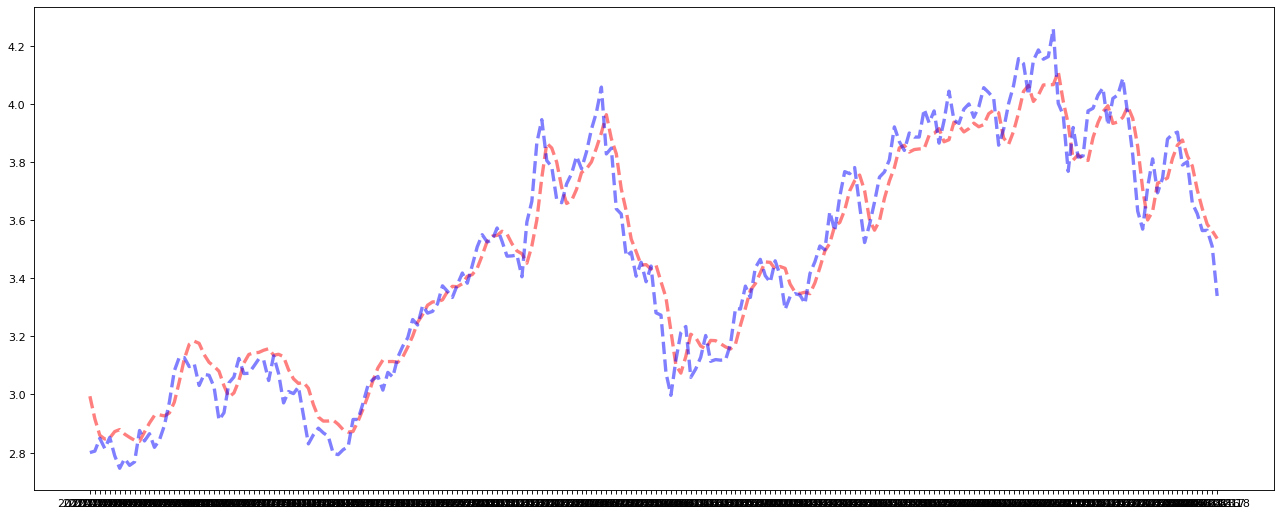

In [27]:
plt.figure(figsize=(20,8),dpi=80)
plt.plot(df1['日期'],df1['预测最高成交价'],color= 'red',alpha = 0.5,linestyle='--',linewidth=3)
plt.plot(df1['日期'],df1['实际最高成交价'],color= 'blue',alpha = 0.5,linestyle='--',linewidth=3)
plt.show()